# State evolution after MI
Interested in finding out how state evolves after MI, to see if they will end up in desirable cycling states

## Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.style.use(["seaborn-dark"])
plt.rcParams["figure.figsize"] = (16, 9)
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["axes.titlesize"] = 24
plt.rcParams["xtick.labelsize"] = 18
plt.rcParams["ytick.labelsize"] = 18
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["font.family"] = 'serif'

import numpy as np

import centrex_TlF
from centrex_TlF import UncoupledBasisState
from state_prep.electric_fields import ElectricField, E_field_ring, E_field_tanh
from state_prep.hamiltonians import SlowHamiltonian
from state_prep.magnetic_fields import MagneticField, Bx_field_tanh
from state_prep.simulator import Simulator
from state_prep.trajectory import Trajectory
from state_prep.utils import vector_to_state

### Example of state crossing

Here we look at an example of state crossing at small field

## Define molecule trajectory

In [38]:
# initial eletric field in V/cm
V1 = 50

#initial distance
z1 = 0

decayl = 1e-4

# define trajectory of molecules
trajectory = Trajectory(Rini = np.array((0,0,0)), Vini = np.array((0,0,184.)), zfin = decayl*2)

## Define electric field

In [39]:
# defining an decaying electric field in the form of 1 - tanh(z)
E_R = lambda R: E_field_tanh(R, z0 = z1, V = V1, l = decayl  )
electric_field = ElectricField(E_R)

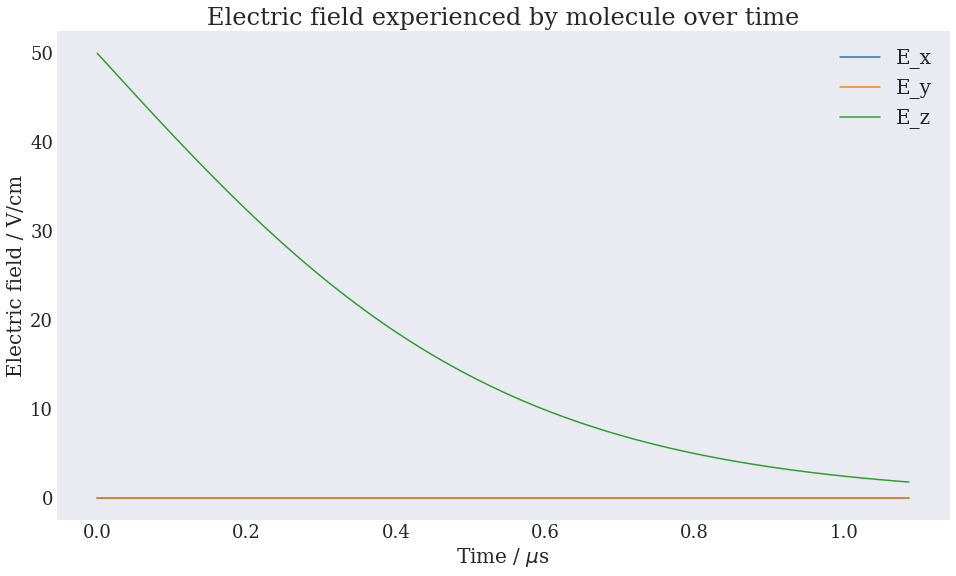

In [40]:
# Plot the electric field as a check:
electric_field.plot(trajectory)

## Define magnetic field
Define the magnetic field in Gauss. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [41]:
B = np.array((0,0,1e-5))
#B = np.array((0.2,0.45,0.1))
#B = np.array((0,0,1))
magnetic_field = MagneticField(lambda R: np.repeat(B.reshape(3,1),R.shape[1], axis = 1))

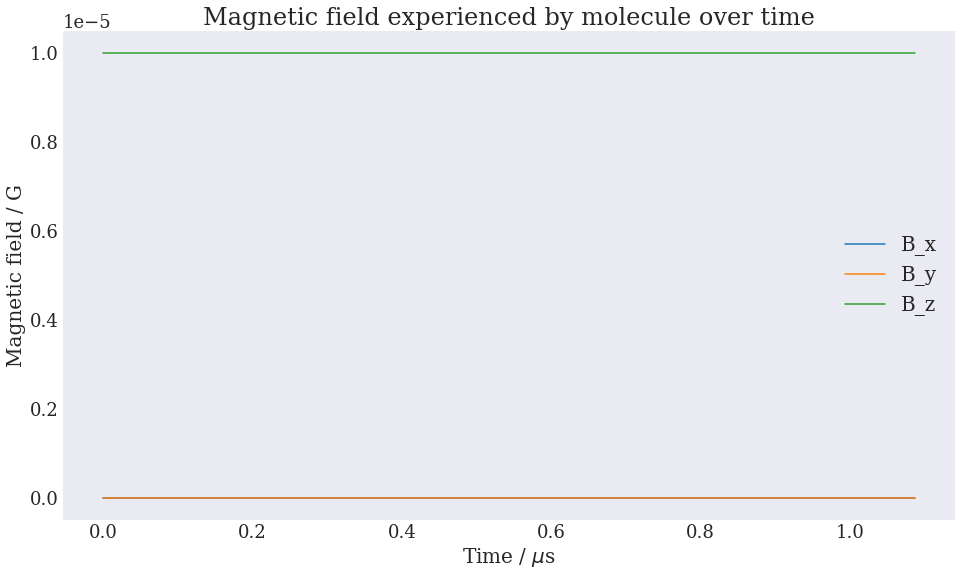

In [42]:
magnetic_field.plot(trajectory)

## Initial states
Define approximate initial states here.

In [261]:
#Define some useful approximate states

#J1_up = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))
J1_up = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))
J1_down = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

initial_states_approx = [J1_up, J1_down]

## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 2 states; J = 1 and 3 are absolutely required since the electric field couples J = 2 to these, J = 0 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [262]:
Js = [0,1,2,3]
hamiltonian = SlowHamiltonian(Js,trajectory, electric_field, magnetic_field)

## Time-evolution
Next define a Simulator and use it to numerically integrate the Schroedinger equation to see how the states evolve as the electric field is ramped down. 

In [263]:
simulator = Simulator(trajectory, electric_field, magnetic_field, initial_states_approx, hamiltonian)

In [264]:
result = simulator.run()

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:07<00:00, 1342.78it/s]


## Results

First we look at how the eigenstates evolve in time, the states are labeled its initial eigenstate. 

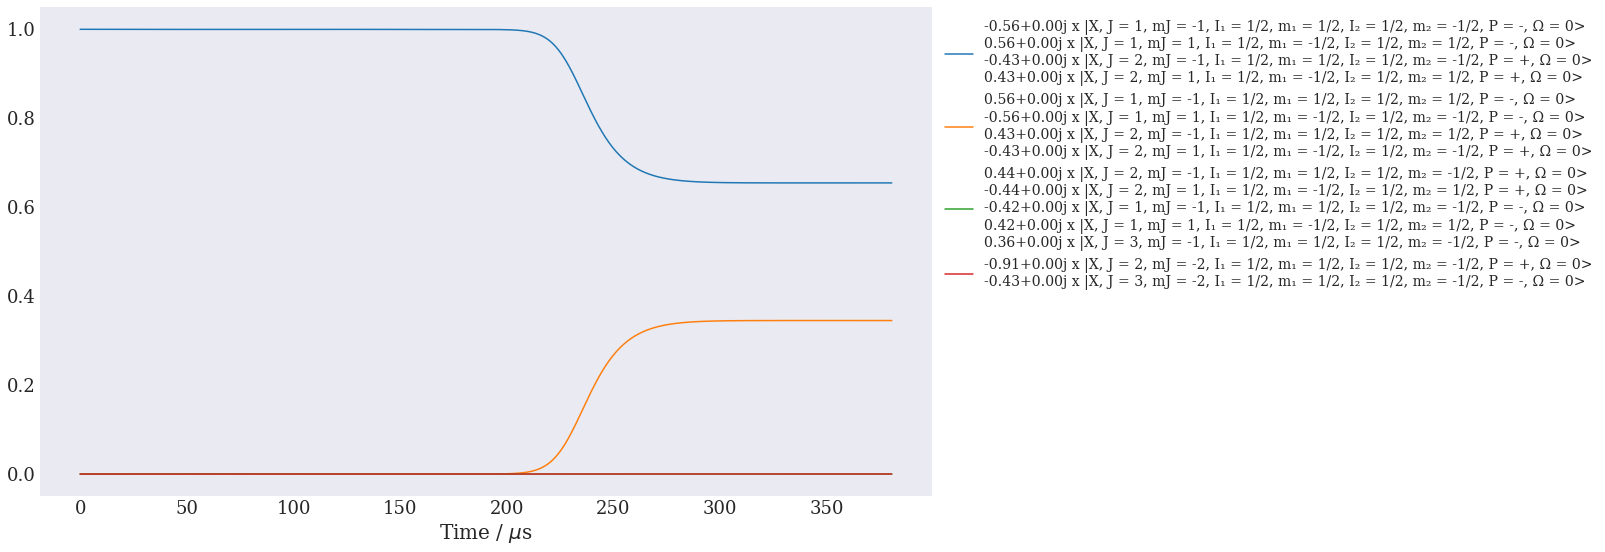

In [265]:
# evolution of (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

initial_state = result.initial_states[1]
large_prob_states = result.find_large_prob_states(initial_state, N=4)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, tolerance = 0.2)
ax.legend(fontsize = 14, bbox_to_anchor = (1,1))

It is evident that there are transitions into different eigenstates from our initial state. For a fully adiabatic evolution, we expect the initial state to stay constantly at 1. 

In [266]:

QN = result.hamiltonian.QN
final_state_vec_J1_down = result.psis[-1,1,:]
final_state_J1_down = (vector_to_state(final_state_vec_J1_down, QN)
                       .order_by_amp())

print('initial -> final (hyperfine basis)')
print("|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 > ->")
final_state_J1_down.transform_to_coupled().print_state(probabilities = True)

initial -> final (hyperfine basis)
|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 > ->
+0.7486+0.0000j x |X, J = 1, F₁ = 1/2, F = 1, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.1217+0.0000j x |X, J = 1, F₁ = 1/2, F = 1, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.1217+0.0000j x |X, J = 1, F₁ = 1/2, F = 1, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>


In [267]:

QN = result.hamiltonian.QN
final_state_vec_J1_up = result.psis[-1,0,:]
final_state_J1_up = (vector_to_state(final_state_vec_J1_up, QN)
                       .order_by_amp())

print('initial -> final (hyperfine basis)')
print("|J = 1, mJ = 0, m1 = 1/2, m2 = 1/2 > ->")
final_state_J1_up.transform_to_coupled().print_state(probabilities = True)

initial -> final (hyperfine basis)
|J = 1, mJ = 0, m1 = 1/2, m2 = 1/2 > ->
+0.1913+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 2, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.1888+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = -2, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.3094+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.3071+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>


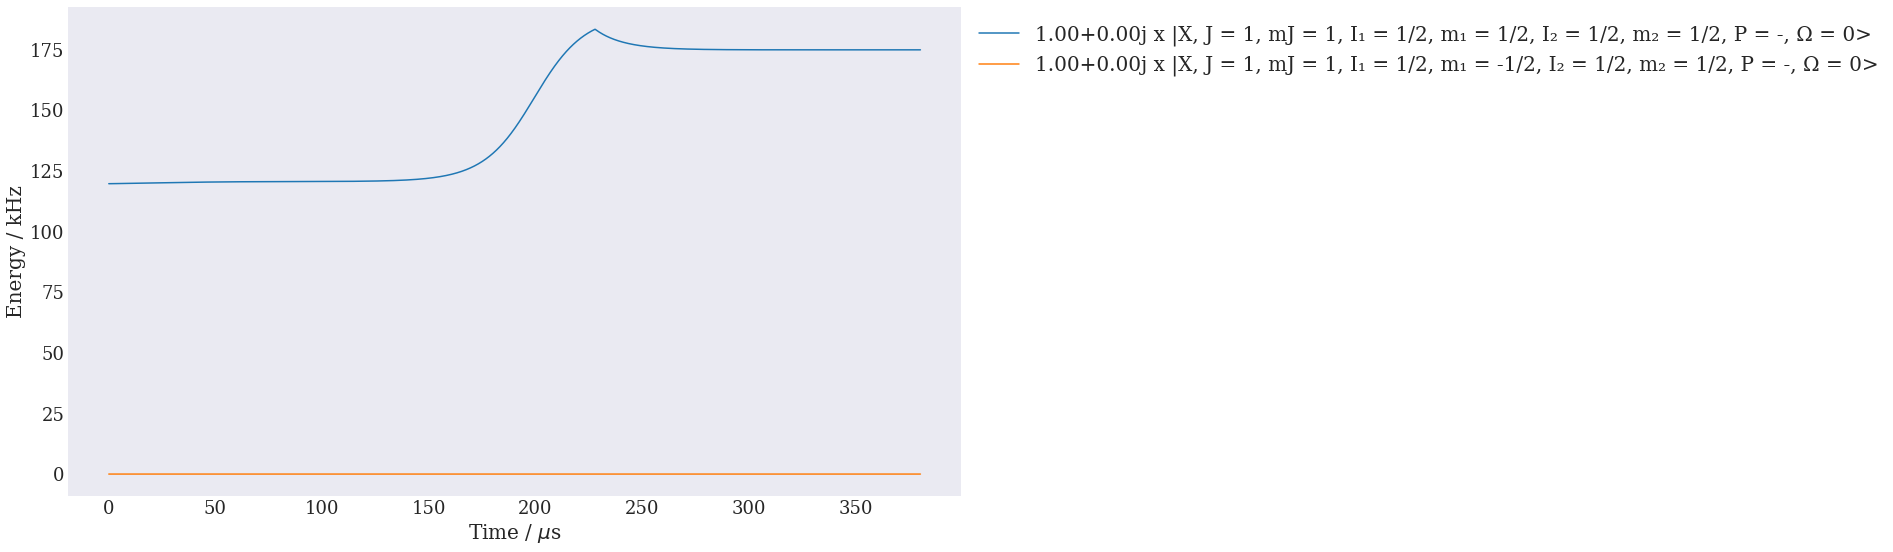

In [268]:
fig, ax = plt.subplots()
result.plot_state_energies([J1_up, J1_down], zero_state =J1_down, ax = ax)
ax.legend(bbox_to_anchor = (1,1))

---

Next, we show the case where magnetic field causing unwanted transition

In [48]:
# initial eletric field in V/cm
V1 = 50

#initial distance
z1 = 0

decayl = 1e-4

# define trajectory of molecules
trajectory = Trajectory(Rini = np.array((0,0,0)), Vini = np.array((0,0,184.)), zfin = decayl*2)

## Define electric field

In [49]:
# defining an decaying electric field in the form of 1 - tanh(z)
E_R = lambda R: E_field_tanh(R, z0 = z1, V = V1, l = decayl  )
electric_field = ElectricField(E_R)

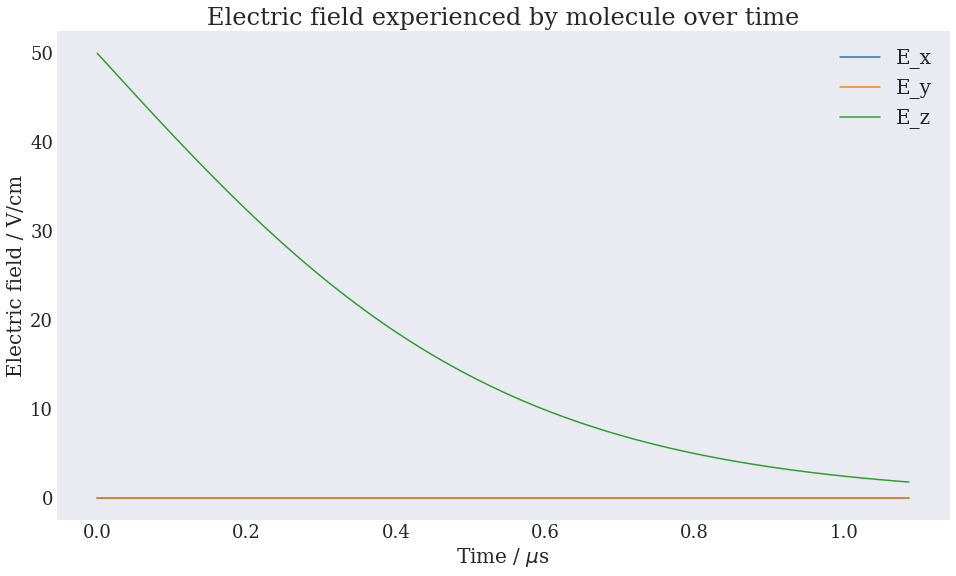

In [50]:
# Plot the electric field as a check:
electric_field.plot(trajectory)

## Define magnetic field
Define the magnetic field in Gauss. Using a constant field, either a nominal small field (so mF states become non-degenerate eigenstates of the Hamiltonian) or something resembilng Earth's magnetic field.

In [290]:
#B = np.array((0,0,1e-5))
#here the magnetic field has components other than the z-axis
B = np.array((1,0,0))
#B = np.array((0,0,1))
magnetic_field = MagneticField(lambda R: np.repeat(B.reshape(3,1),R.shape[1], axis = 1))

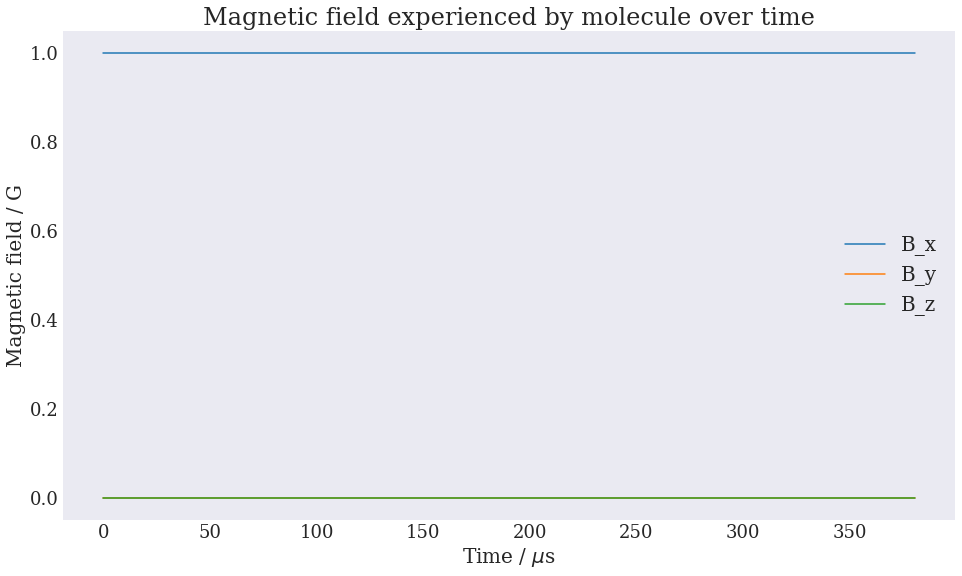

In [291]:
magnetic_field.plot(trajectory)

---

### To avoid the crossings, we keep the field above 30V/cm

In [57]:
# initial eletric field in V/cm
V1 = 10
Vc = 0
#initial distance
z1 = 1e-2

decayl =1e-2

# define trajectory of molecules
trajectory = Trajectory(Rini = np.array((0,0,0)), Vini = np.array((0,0,184.)), zfin = decayl*15)

In [58]:
# defining an decaying electric field in the form of 1 - tanh(z)
E_R = lambda R: E_field_tanh(R, z0 = decayl*5, V = V1, l = decayl  ) + E_field_tanh(R, z0 = z1, V = Vc, l = decayl*1000000  )
electric_field = ElectricField(E_R)

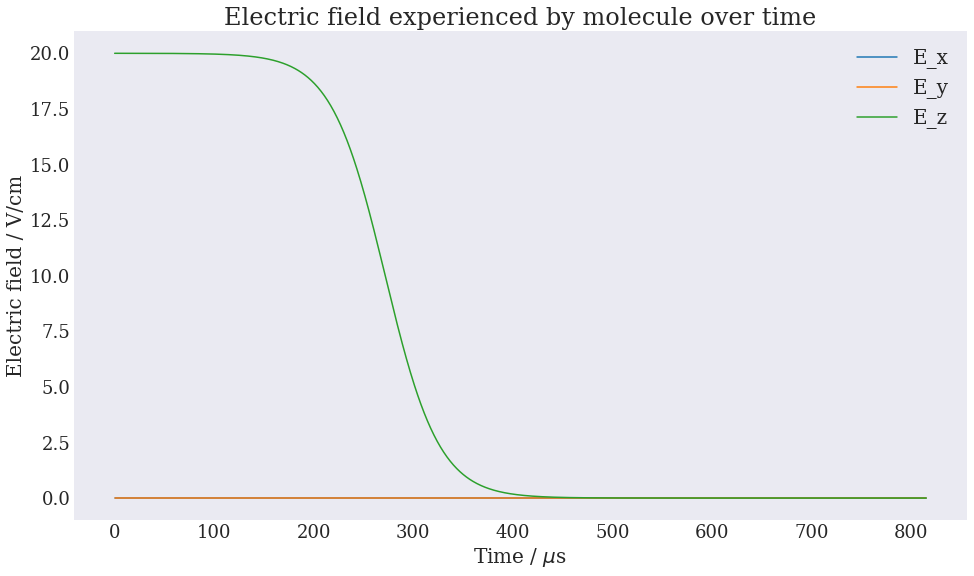

In [59]:
# Plot the electric field as a check:
electric_field.plot(trajectory)

In [60]:
# initial eletric field in V/cm
B1 = 1
Bc = 50
#initial distance
z1 = 0

decaylb =decayl

# define trajectory of molecules
trajectoryb = Trajectory(Rini = np.array((0,0,0)), Vini = np.array((0,0,184.)), zfin = decayl*7)

In [61]:
#B = np.array((0,0,1e-5))
Bc = np.array((0,0,0.1))
B_R = lambda R: Bx_field_tanh(R, x0 = z1, B0 = B1, l = decaylb) + np.repeat(Bc.reshape(3,1),R.shape[1], axis = 1)
magnetic_field = MagneticField(B_R)

#B = np.array((0.0,1,0.001))
#B = np.array((0,0.6,0.01))
#magnetic_field = MagneticField(lambda R: np.repeat(B.reshape(3,1),R.shape[1], axis = 1))

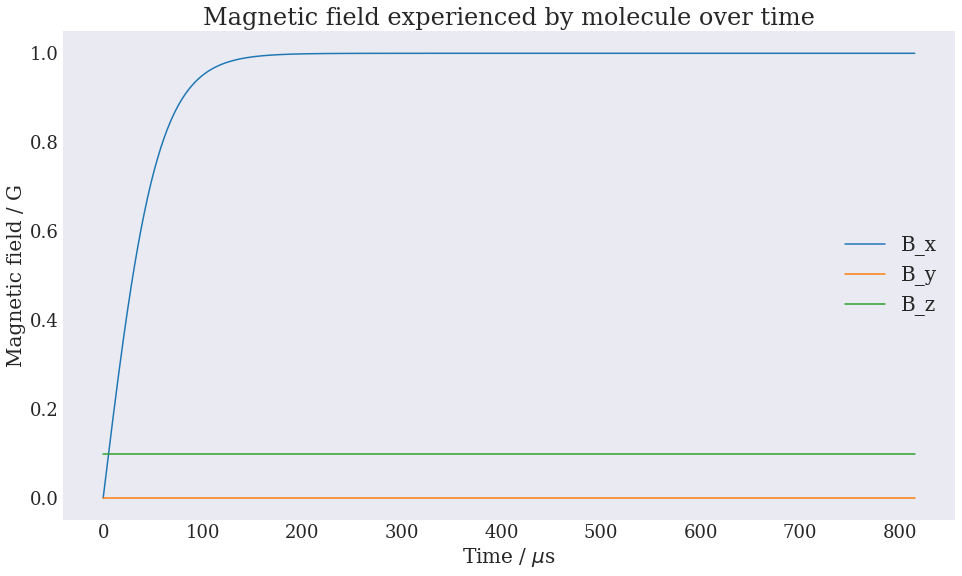

In [62]:
magnetic_field.plot(trajectory)

## Initial states
Define approximate initial states here.

In [63]:
#Define some useful approximate states

#J1_up = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))
J1_up = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))
J1_down = (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = +1/2, P = -1, Omega = 0, electronic_state='X'))
J1_down1 = (1*UncoupledBasisState(J = 1, mJ = 0, I1 = 1/2, m1 = 1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))
initial_states_approx = [J1_up, J1_down]

## Define slowly varying Hamiltonian
Define a Hamiltonian object that represents the slowly varying part of the Hamiltonian (i.e. everything except the microwaves). Using J = 0-3 here since we're interested in the time-evolution of J = 2 states; J = 1 and 3 are absolutely required since the electric field couples J = 2 to these, J = 0 is not strictly necessary. Since the Stark energies are << the rotational energies, we mostly just need the J of interest $\pm 1$.

In [64]:
Js = [0,1,2,3]
hamiltonian = SlowHamiltonian(Js,trajectory, electric_field, magnetic_field)

## Time-evolution
Next define a Simulator and use it to numerically integrate the Schroedinger equation to see how the states evolve as the electric field is ramped down. 

In [65]:
simulator = Simulator(trajectory, electric_field, magnetic_field, initial_states_approx, hamiltonian)

In [66]:
result = simulator.run()

100%|████████████████████████████████████████████████████████████████████████████| 9999/9999 [00:08<00:00, 1182.61it/s]


## Results

First we look at how the eigenstates evolve in time, the states are labeled its initial eigenstate. 

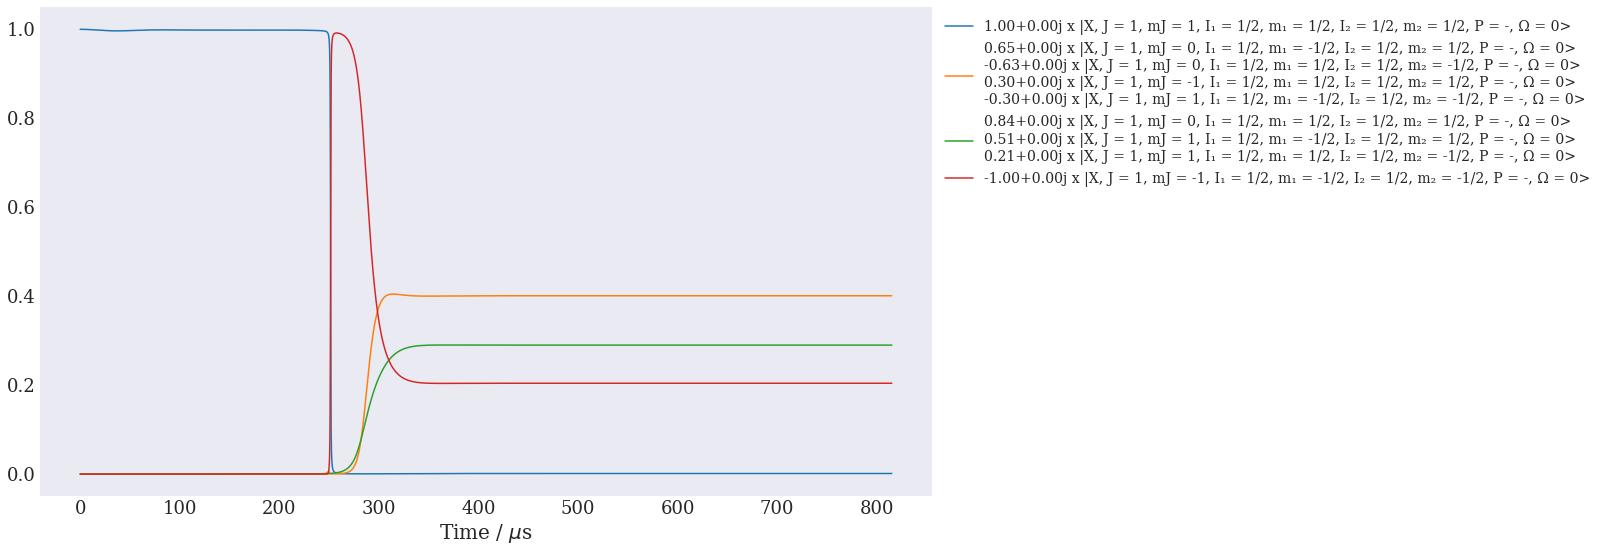

In [67]:
# evolution of (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

initial_state = result.initial_states[0]
large_prob_states = result.find_large_prob_states(initial_state, N=4)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, tolerance = 0.2)
ax.legend(fontsize = 14, bbox_to_anchor = (1,1))

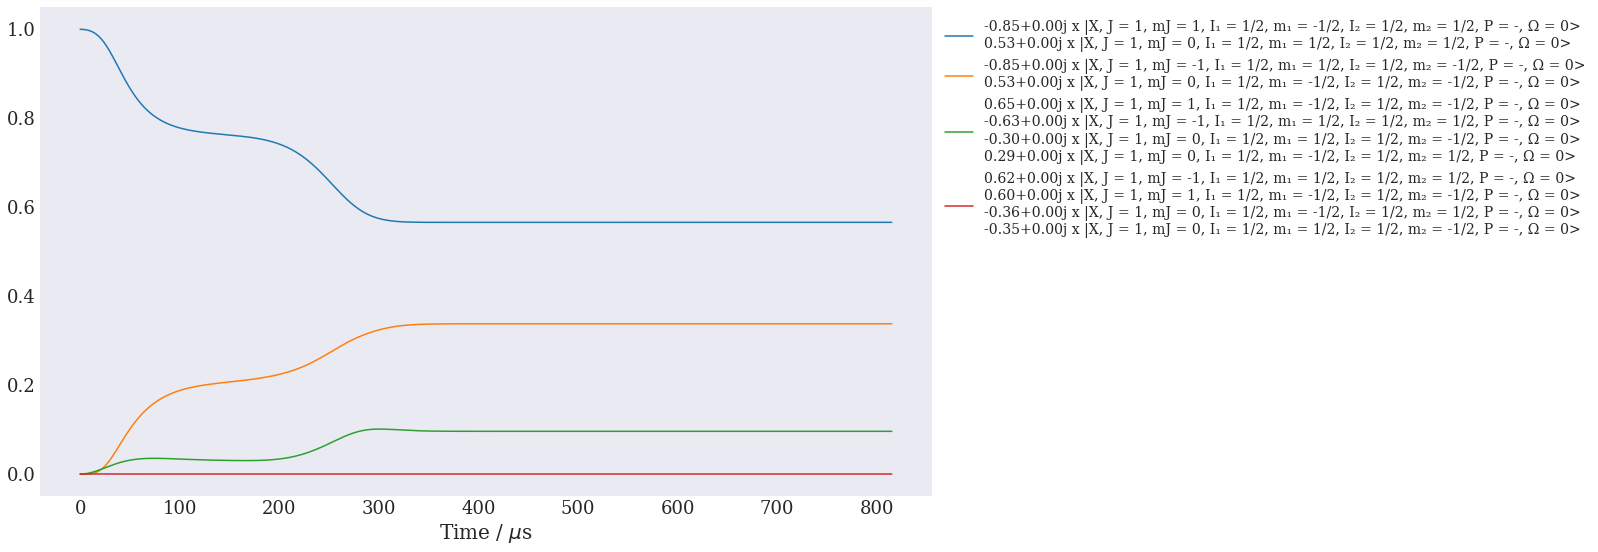

In [68]:
# evolution of (1*UncoupledBasisState(J = 1, mJ = 1, I1 = 1/2, m1 = -1/2, I2 = 1/2, m2 = 1/2, P = -1, Omega = 0, electronic_state='X'))

initial_state = result.initial_states[1]
large_prob_states = result.find_large_prob_states(initial_state, N=4)
fig, ax = plt.subplots()
result.plot_state_probabilities(large_prob_states, initial_state, ax = ax, tolerance = 0.2)
ax.legend(fontsize = 14, bbox_to_anchor = (1,1))

Text(0, 0.5, '<mJ>')

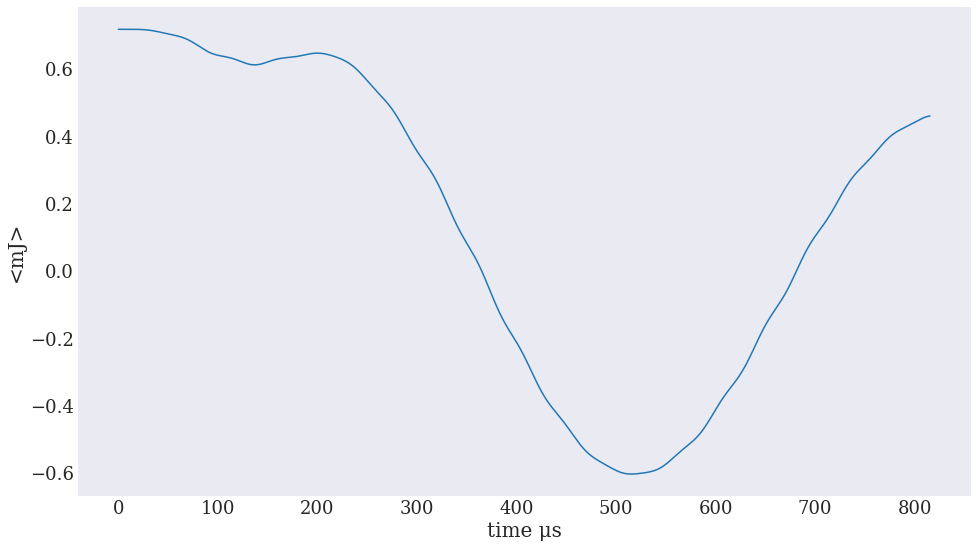

In [69]:
# plotting the expected mJ value over time

STATENUMBER = 1
mtime = []
for j in range(len(result.psis[:,0,0])):
    test_state = result.hamiltonian.QN
    mlist = []
    for i in range(len(test_state)):
        mlist.append(test_state[i].mJ)
    expectedmJ = np.sum(np.abs(result.psis[j,STATENUMBER,:])**2 * mlist)
    mtime.append(expectedmJ)

T = trajectory.get_T()
t_array = np.linspace(0,T,10000)
plt.plot(t_array/1e-6,mtime)
plt.xlabel('time μs')
plt.ylabel('<mJ>')

In [70]:
QN = result.hamiltonian.QN
final_state_vec_J1_down = result.psis[-1,0,:]
final_state_J1_down = (vector_to_state(final_state_vec_J1_down, QN)
                       .order_by_amp())

print('initial -> final (hyperfine basis)')
print("|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->")
final_state_J1_down.transform_to_coupled().print_state(probabilities = True)

initial -> final (hyperfine basis)
|J = 1, mJ = 1, m1 = 1/2, m2 = 1/2 > ->
+0.6188+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 2, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.3287+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0290+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = 0, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>
+0.0104+0.0000j x |X, J = 1, F₁ = 3/2, F = 2, mF = -1, I₁ = 1/2, I₂ = 1/2, P = -, Ω = 0>


In [71]:
QN = result.hamiltonian.QN
final_state_vec_J1_down = result.psis[0,1,:]
final_state_J1_down = (vector_to_state(final_state_vec_J1_down, QN)
                       .order_by_amp())

print('initial -> final (hyperfine basis)')
print("|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 > ->")
final_state_J1_down.print_state()

initial -> final (hyperfine basis)
|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 > ->
-0.8438+0.0000j x |X, J = 1, mJ = 1, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>
+0.5309+0.0000j x |X, J = 1, mJ = 0, I₁ = 1/2, m₁ = 1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>


In [72]:
QN = result.hamiltonian.QN
final_state_vec_J1_down = result.psis[-1,1,:]
final_state_J1_down = (vector_to_state(final_state_vec_J1_down, QN)
                       .order_by_amp())

print('initial -> final (hyperfine basis)')
print("|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 > ->")
final_state_J1_down.print_state(tol = 1e-2,probabilities=True)

initial -> final (hyperfine basis)
|J = 1, mJ = 1, m1 = -1/2, m2 = 1/2 > ->
+0.4953+0.0000j x |X, J = 1, mJ = 1, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>
+0.2999+0.0000j x |X, J = 1, mJ = 0, I₁ = 1/2, m₁ = 1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>
+0.0731+0.0000j x |X, J = 1, mJ = -1, I₁ = 1/2, m₁ = 1/2, I₂ = 1/2, m₂ = -1/2, P = -, Ω = 0>
+0.0478+0.0000j x |X, J = 1, mJ = 1, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = -1/2, P = -, Ω = 0>
+0.0438+0.0000j x |X, J = 1, mJ = 0, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = -1/2, P = -, Ω = 0>
+0.0177+0.0000j x |X, J = 1, mJ = 0, I₁ = 1/2, m₁ = 1/2, I₂ = 1/2, m₂ = -1/2, P = -, Ω = 0>
+0.0132+0.0000j x |X, J = 1, mJ = -1, I₁ = 1/2, m₁ = 1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>
+0.0045+0.0000j x |X, J = 1, mJ = 1, I₁ = 1/2, m₁ = 1/2, I₂ = 1/2, m₂ = -1/2, P = -, Ω = 0>
+0.0040+0.0000j x |X, J = 1, mJ = 0, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>
+0.0007+0.0000j x |X, J = 1, mJ = -1, I₁ = 1/2, m₁ = -1/2, I₂ = 1/2, m₂ = 1/2, P = -, Ω = 0>


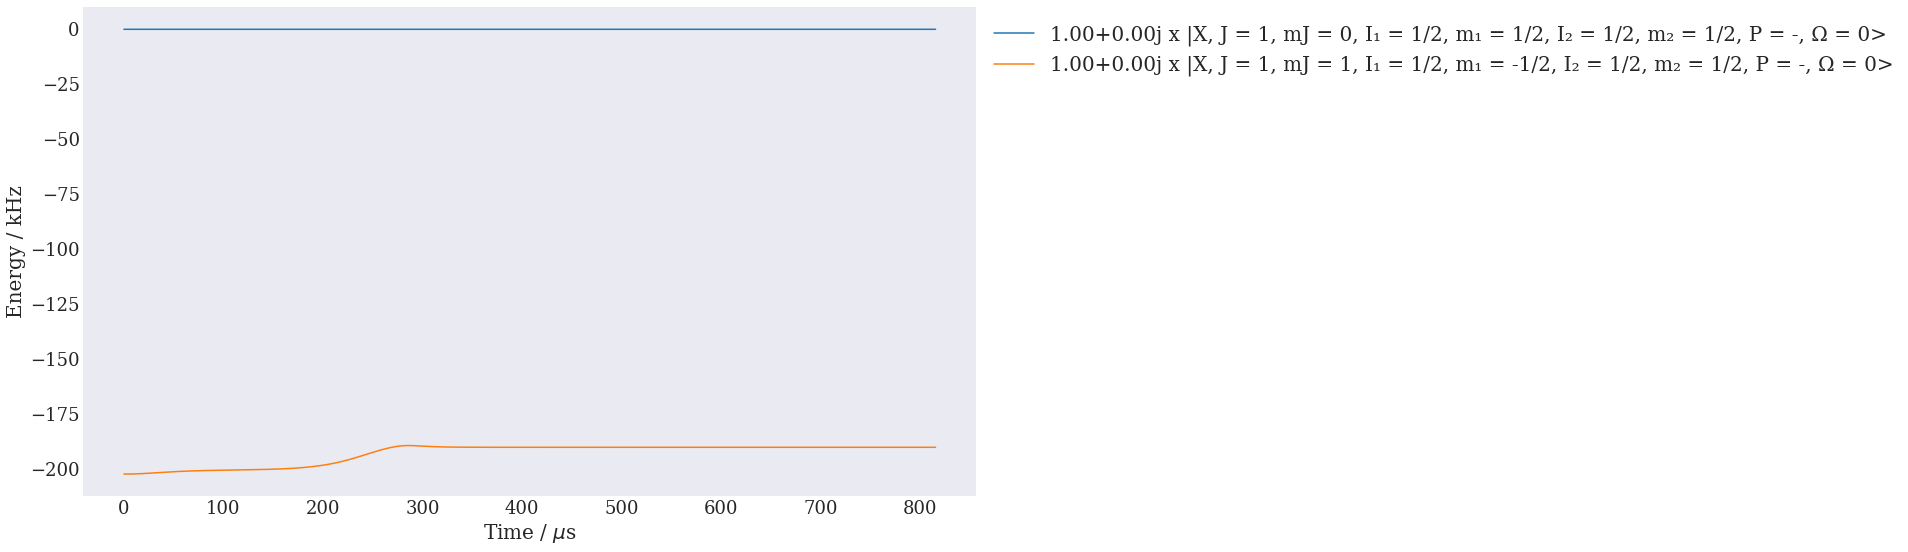

In [73]:
fig, ax = plt.subplots()
result.plot_state_energies([J1_down1, J1_down], zero_state = J1_down1, ax = ax)
ax.legend(bbox_to_anchor = (1,1))